#**Aula 1: Obtendo os dados**

##**Importando os dados**

In [1]:
import pandas as pd

In [2]:
url = 'https://raw.githubusercontent.com/alura-cursos/regressao_boosting/main/Dados/dados_automoveis.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,Marca,Modelo,Ano,Tipo_combustivel,Potencia_motor,Cilindros_motor,Tipo_transmissao,Rodas_motrizes,Numero_portas,Tamanho,Estilo,Consumo_estrada_milhas,Consumo_cidade_milhas,Valor($)
0,GMC,Envoy XL,2005,gasolina comum,275.0,6.0,automatico,tracao traseira,4.0,grande,SUV 4 portas,18,13,29695
1,Volkswagen,Passat,2016,gasolina comum,170.0,4.0,automatico,tracao dianteira,4.0,medio,seda,38,25,30495
2,Honda,Odyssey,2016,gasolina comum,248.0,6.0,automatico,tracao dianteira,4.0,grande,minivan de passageiros,28,19,37650
3,Chevrolet,Cruze,2015,gasolina comum,138.0,4.0,manual,tracao dianteira,4.0,medio,seda,36,25,16170
4,Volvo,740,1991,gasolina comum,162.0,4.0,automatico,tracao traseira,4.0,medio,seda,20,17,2000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10918 entries, 0 to 10917
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Marca                   10918 non-null  object 
 1   Modelo                  10918 non-null  object 
 2   Ano                     10918 non-null  int64  
 3   Tipo_combustivel        10918 non-null  object 
 4   Potencia_motor          10862 non-null  float64
 5   Cilindros_motor         10888 non-null  float64
 6   Tipo_transmissao        10918 non-null  object 
 7   Rodas_motrizes          10918 non-null  object 
 8   Numero_portas           10916 non-null  float64
 9   Tamanho                 10918 non-null  object 
 10  Estilo                  10918 non-null  object 
 11  Consumo_estrada_milhas  10918 non-null  int64  
 12  Consumo_cidade_milhas   10918 non-null  int64  
 13  Valor($)                10918 non-null  int64  
dtypes: float64(3), int64(4), object(7)
mem

##**Processando os dados**

In [6]:
df.duplicated().sum()

709

In [7]:
dados_limpos = df.drop_duplicates()
dados_limpos.reset_index(drop=True, inplace=True)

In [8]:
dados_limpos.shape

(10209, 14)

In [9]:
df_final = dados_limpos.copy()

object_columns = df_final.select_dtypes(include='object').columns
df_final[object_columns] = df_final[object_columns].astype('category')

In [10]:
df_final.dtypes

Marca                     category
Modelo                    category
Ano                          int64
Tipo_combustivel          category
Potencia_motor             float64
Cilindros_motor            float64
Tipo_transmissao          category
Rodas_motrizes            category
Numero_portas              float64
Tamanho                   category
Estilo                    category
Consumo_estrada_milhas       int64
Consumo_cidade_milhas        int64
Valor($)                     int64
dtype: object

#**Aula 2: Utilizando o XGBoost**

##**Separando os dados em treino e teste**

In [11]:
X = df_final.drop(['Valor($)'], axis=1)
y = df_final['Valor($)']

In [12]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=4256)

##**Realizando previsões com a API do Scikit-Learn**

In [13]:
import xgboost as xgb

In [14]:
xgb.__version__

'2.0.3'

In [15]:
modelo = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators=100)

modelo.fit(X_treino, y_treino)
preds = modelo.predict(X_teste)

##**Obtendo métricas de desempenho**

In [16]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_teste, preds)
print(f'MSE: {mse:.2f}')

MSE: 10073066.72


In [17]:
rmse = mean_squared_error(y_teste, preds, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 3173.81


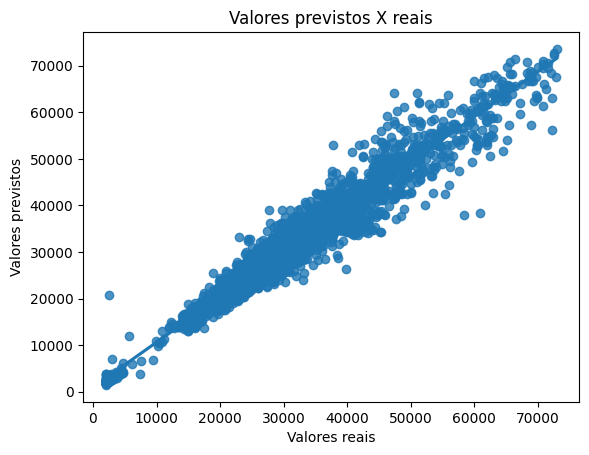

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_teste, y=preds)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('Valores previstos X reais')
plt.show()

##**Realizando previsões com a API nativa do XGBoost**

In [19]:
dtreino = xgb.DMatrix(X_treino, y_treino, enable_categorical=True)
dteste = xgb.DMatrix(X_teste, y_teste, enable_categorical=True)

In [20]:
params = {'objective': 'reg:squarederror'}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=100
)

preds = modelo.predict(dteste)

In [21]:
rmse = mean_squared_error(dteste.get_label(), preds, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 3173.81


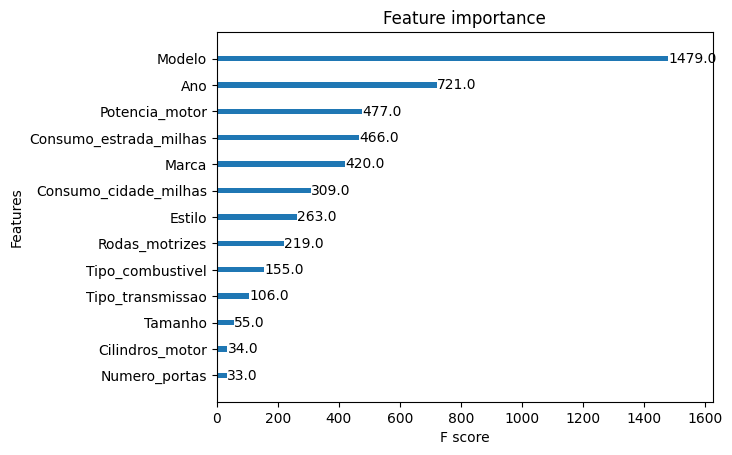

In [22]:
xgb.plot_importance(modelo)
plt.grid(False)
plt.show()

#**Aula 3: Realizando a validação do modelo**

##**Utilizando conjuntos de validação durante o treinamento**

In [23]:
params = {'objective': 'reg:squarederror'}
n = 100

evals = [(dtreino, 'treino'), (dteste, 'validação')]

modelo = xgb.train(
    params=params,
    dtrain = dtreino,
    num_boost_round = n,
    evals=evals)

[0]	treino-rmse:11397.44777	validação-rmse:11428.38371
[1]	treino-rmse:8419.92421	validação-rmse:8539.42830
[2]	treino-rmse:6425.02430	validação-rmse:6627.03654
[3]	treino-rmse:5040.19130	validação-rmse:5338.70995
[4]	treino-rmse:4135.71776	validação-rmse:4497.91778
[5]	treino-rmse:3549.66309	validação-rmse:3973.99520
[6]	treino-rmse:3190.99309	validação-rmse:3666.71737
[7]	treino-rmse:2931.74504	validação-rmse:3437.90343
[8]	treino-rmse:2759.44326	validação-rmse:3294.24403
[9]	treino-rmse:2644.09478	validação-rmse:3206.29466
[10]	treino-rmse:2571.02253	validação-rmse:3149.67446
[11]	treino-rmse:2516.57119	validação-rmse:3140.16668
[12]	treino-rmse:2476.27252	validação-rmse:3119.20341
[13]	treino-rmse:2439.29399	validação-rmse:3111.99218
[14]	treino-rmse:2406.31852	validação-rmse:3106.36832
[15]	treino-rmse:2393.68691	validação-rmse:3093.60941
[16]	treino-rmse:2373.54123	validação-rmse:3094.85282
[17]	treino-rmse:2354.34332	validação-rmse:3084.12295
[18]	treino-rmse:2337.33734	validaçã

In [24]:
params = {'objective': 'reg:squarederror'}
n = 100

evals = [(dtreino, 'treino'), (dteste, 'validação')]

modelo = xgb.train(
    params=params,
    dtrain = dtreino,
    num_boost_round = n,
    evals=evals,
    verbose_eval=10)

[0]	treino-rmse:11397.44777	validação-rmse:11428.38371
[10]	treino-rmse:2571.02253	validação-rmse:3149.67446
[20]	treino-rmse:2305.79213	validação-rmse:3087.42122
[30]	treino-rmse:2237.76852	validação-rmse:3080.11840
[40]	treino-rmse:2193.78307	validação-rmse:3078.00977
[50]	treino-rmse:2157.67397	validação-rmse:3084.26489
[60]	treino-rmse:2131.62039	validação-rmse:3096.15417
[70]	treino-rmse:2113.33384	validação-rmse:3115.08400
[80]	treino-rmse:2100.46985	validação-rmse:3138.13986
[90]	treino-rmse:2087.21157	validação-rmse:3155.96127
[99]	treino-rmse:2078.52719	validação-rmse:3173.80950


In [25]:
params = {'objective': 'reg:squarederror'}
n = 1000

evals = [(dtreino, 'treino'), (dteste, 'validação')]

modelo = xgb.train(
    params=params,
    dtrain = dtreino,
    num_boost_round = n,
    evals=evals,
    early_stopping_rounds=10)

[0]	treino-rmse:11397.44777	validação-rmse:11428.38371
[1]	treino-rmse:8419.92421	validação-rmse:8539.42830
[2]	treino-rmse:6425.02430	validação-rmse:6627.03654
[3]	treino-rmse:5040.19130	validação-rmse:5338.70995
[4]	treino-rmse:4135.71776	validação-rmse:4497.91778
[5]	treino-rmse:3549.66309	validação-rmse:3973.99520
[6]	treino-rmse:3190.99309	validação-rmse:3666.71737
[7]	treino-rmse:2931.74504	validação-rmse:3437.90343
[8]	treino-rmse:2759.44326	validação-rmse:3294.24403
[9]	treino-rmse:2644.09478	validação-rmse:3206.29466
[10]	treino-rmse:2571.02253	validação-rmse:3149.67446
[11]	treino-rmse:2516.57119	validação-rmse:3140.16668
[12]	treino-rmse:2476.27252	validação-rmse:3119.20341
[13]	treino-rmse:2439.29399	validação-rmse:3111.99218
[14]	treino-rmse:2406.31852	validação-rmse:3106.36832
[15]	treino-rmse:2393.68691	validação-rmse:3093.60941
[16]	treino-rmse:2373.54123	validação-rmse:3094.85282
[17]	treino-rmse:2354.34332	validação-rmse:3084.12295
[18]	treino-rmse:2337.33734	validaçã

##**Aplicando a validação cruzada**

In [26]:
params = {'objective': 'reg:squarederror'}

cv_resultados = xgb.cv(dtrain=dtreino, params=params, nfold=5, num_boost_round=1000,
                       early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=4789)

cv_resultados

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11398.949602,46.609099,11539.320703,224.497986
1,8418.181666,32.499322,8690.070480,177.475579
2,6403.130361,27.408742,6796.085157,146.144384
3,5026.871579,39.968981,5552.493340,166.413461
4,4134.591712,38.523580,4781.077404,172.901336
5,3553.131124,29.806871,4300.341884,183.813002
6,3163.835612,36.848517,3987.473444,184.019532
7,2912.866675,34.141880,3799.559420,195.232671
8,2741.574008,26.676719,3672.755120,201.076161
9,2614.550836,21.733377,3587.121299,208.258698


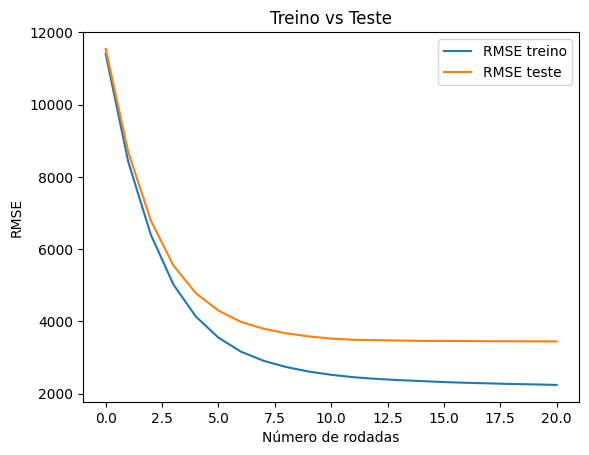

In [27]:
iteracoes = range(len(cv_resultados))

plt.plot(iteracoes, cv_resultados['train-rmse-mean'], label='RMSE treino')
plt.plot(iteracoes, cv_resultados['test-rmse-mean'], label='RMSE teste')
plt.title('Treino vs Teste')
plt.xlabel('Número de rodadas')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#**Aula 4: Ajustando hiperparâmetros do XGBoost**

##**Aplicando a busca em grade por hiperparâmetros**

In [28]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'colsample_bytree': [0.6, 1],
    'subsample': [0.5, 0.8, 1],
    'max_depth': [3, 5, 10]
}

gbm = xgb.XGBRegressor(enable_categorical=True)

grid = GridSearchCV(
    estimator = gbm,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

grid.fit(X, y)

print('Melhores hiperparâmetros encontrados: ', grid.best_params_)
print('Menor RMSE encontrado: ', np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores hiperparâmetros encontrados:  {'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1}
Menor RMSE encontrado:  2974.291934693634


##**Entendendo o impacto da taxa de aprendizagem**

[0]	treino-rmse:15651.68812	validação-rmse:15589.38285
[100]	treino-rmse:8270.80776	validação-rmse:8362.59559
[200]	treino-rmse:5119.95154	validação-rmse:5337.96464
[300]	treino-rmse:3836.52434	validação-rmse:4125.46494
[400]	treino-rmse:3278.87041	validação-rmse:3616.28511
[500]	treino-rmse:3017.54501	validação-rmse:3380.48210
[600]	treino-rmse:2876.13171	validação-rmse:3248.52867
[700]	treino-rmse:2792.10171	validação-rmse:3169.78583
[800]	treino-rmse:2735.45732	validação-rmse:3118.44255
[900]	treino-rmse:2692.62696	validação-rmse:3080.81938
[999]	treino-rmse:2656.96804	validação-rmse:3050.48769


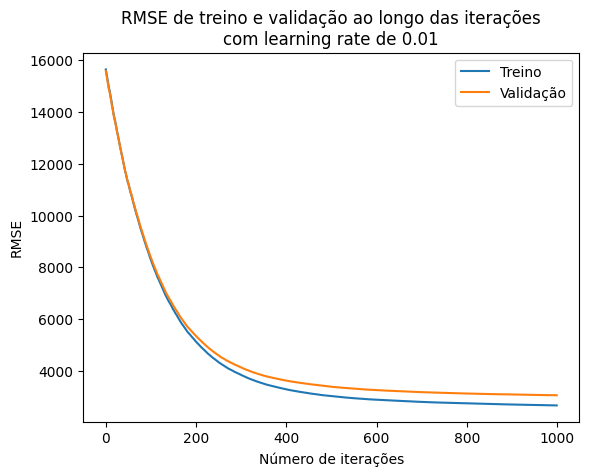

In [29]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.01}

evals_result = {}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtreino, 'treino'), (dteste, 'validação')],
    evals_result=evals_result
)

treino_rmse = evals_result['treino']['rmse']
validacao_rmse = evals_result['validação']['rmse']

plt.plot(treino_rmse, label='Treino')
plt.plot(validacao_rmse, label='Validação')
plt.xlabel('Número de iterações')
plt.ylabel('RMSE')
plt.title('RMSE de treino e validação ao longo das iterações\ncom learning rate de 0.01')
plt.legend()
plt.show()

##**Explorando diferentes taxas de aprendizagem**

[0]	treino-rmse:14566.02760	validação-rmse:14503.12454
[100]	treino-rmse:2728.19216	validação-rmse:3119.95581
[200]	treino-rmse:2511.56224	validação-rmse:2957.90831
[300]	treino-rmse:2431.46238	validação-rmse:2915.75545
[333]	treino-rmse:2406.08222	validação-rmse:2910.64714


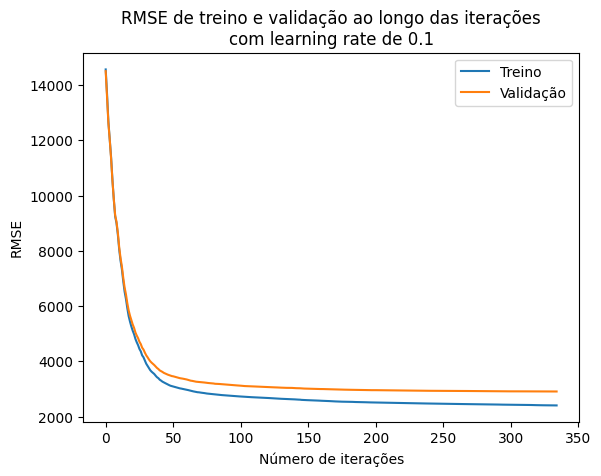

In [30]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.1}

evals_result = {}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtreino, 'treino'), (dteste, 'validação')],
    evals_result=evals_result
)

treino_rmse = evals_result['treino']['rmse']
validacao_rmse = evals_result['validação']['rmse']

plt.plot(treino_rmse, label='Treino')
plt.plot(validacao_rmse, label='Validação')
plt.xlabel('Número de iterações')
plt.ylabel('RMSE')
plt.title('RMSE de treino e validação ao longo das iterações\ncom learning rate de 0.1')
plt.legend()
plt.show()

[0]	treino-rmse:7469.14162	validação-rmse:7414.63268
[83]	treino-rmse:2348.59345	validação-rmse:3004.61532


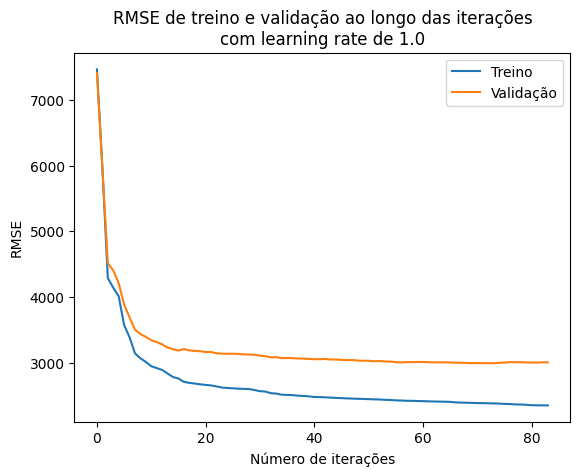

In [31]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 1.0}

evals_result = {}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtreino, 'treino'), (dteste, 'validação')],
    evals_result=evals_result
)

treino_rmse = evals_result['treino']['rmse']
validacao_rmse = evals_result['validação']['rmse']

plt.plot(treino_rmse, label='Treino')
plt.plot(validacao_rmse, label='Validação')
plt.xlabel('Número de iterações')
plt.ylabel('RMSE')
plt.title('RMSE de treino e validação ao longo das iterações\ncom learning rate de 1.0')
plt.legend()
plt.show()

[0]	treino-rmse:12265.48571	validação-rmse:12201.03028
[100]	treino-rmse:2486.25590	validação-rmse:2951.24218
[170]	treino-rmse:2372.98536	validação-rmse:2909.72514


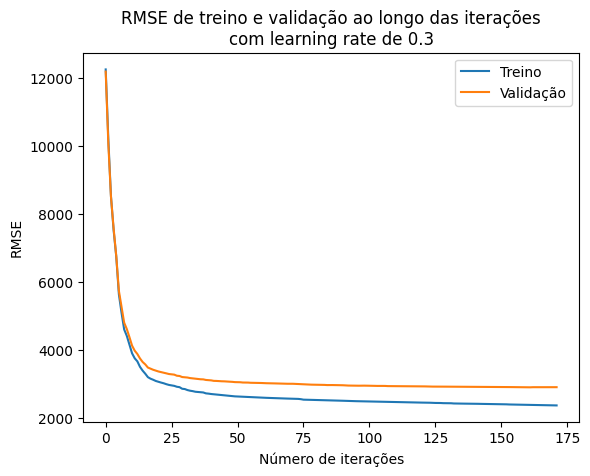

In [32]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

evals_result = {}

modelo = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtreino, 'treino'), (dteste, 'validação')],
    evals_result=evals_result
)

treino_rmse = evals_result['treino']['rmse']
validacao_rmse = evals_result['validação']['rmse']

plt.plot(treino_rmse, label='Treino')
plt.plot(validacao_rmse, label='Validação')
plt.xlabel('Número de iterações')
plt.ylabel('RMSE')
plt.title('RMSE de treino e validação ao longo das iterações\ncom learning rate de 0.3')
plt.legend()
plt.show()

#**Aula 5: Finalizando o modelo**

##**Avaliando o desempenho do modelo final**

In [33]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

modelo_final = xgb.train(
    params=params,
    dtrain=dtreino,
    num_boost_round=170
)

preds = modelo_final.predict(dteste)
rmse = mean_squared_error(dteste.get_label(), preds, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 2912.03


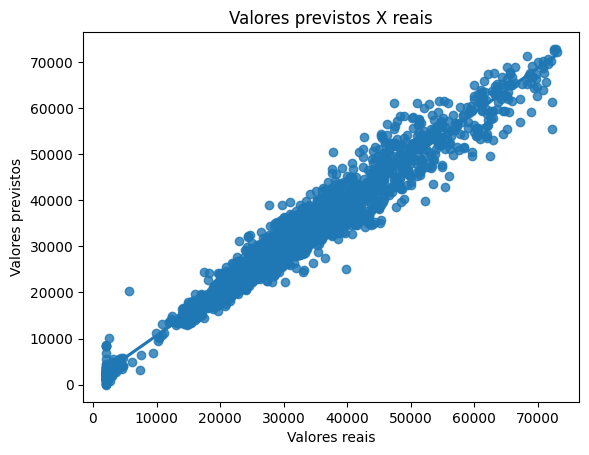

In [34]:
sns.regplot(x=dteste.get_label(), y=preds)
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.title('Valores previstos X reais')
plt.show()

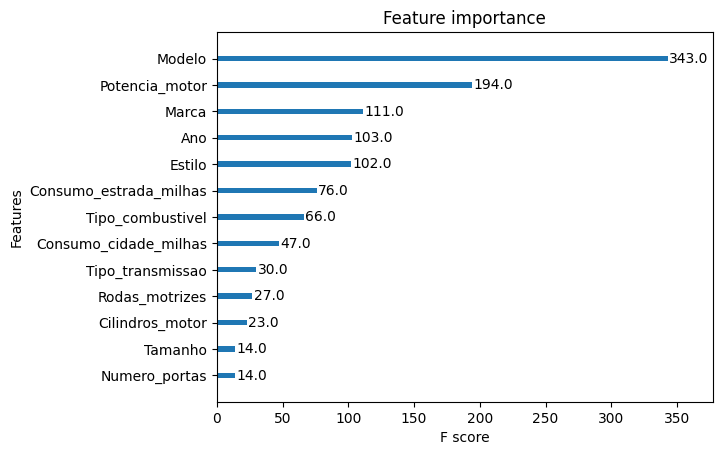

In [35]:
xgb.plot_importance(modelo_final)
plt.grid(False)
plt.show()

##**Comparando o desempenho em dados de treino e teste**

In [36]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

cv_resultados = xgb.cv(dtrain=dtreino, params=params, nfold=5, num_boost_round=1000,
                       early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=4789)

cv_resultados

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,12264.492940,54.439472,12268.379084,282.085119
1,10225.454117,54.786535,10260.074799,261.750777
2,8502.802069,33.841899,8728.174067,193.292337
3,7521.365960,49.511493,7764.530515,197.519667
4,6775.791624,77.664927,7042.443614,168.856827
...,...,...,...,...
214,2271.170363,8.381839,3126.495586,148.009190
215,2270.524017,8.488797,3126.229433,147.851129
216,2270.184715,8.522878,3126.306610,147.904490
217,2268.731551,8.728382,3125.890320,147.244074


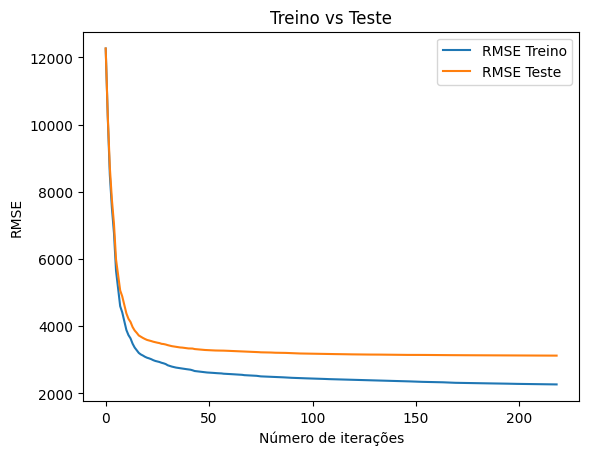

In [37]:
iteracoes = range(len(cv_resultados))

plt.plot(iteracoes, cv_resultados['train-rmse-mean'], label='RMSE Treino')
plt.plot(iteracoes, cv_resultados['test-rmse-mean'], label='RMSE Teste')
plt.title('Treino vs Teste')
plt.xlabel('Número de iterações')
plt.ylabel('RMSE')
plt.legend()
plt.show()

##**Utilizando o modelo com dados novos**

In [38]:
import joblib

joblib.dump(modelo_final, 'modelo_xgb.pkl')

['modelo_xgb.pkl']

In [39]:
modelo = joblib.load('modelo_xgb.pkl')

In [40]:
novos_automoveis = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/regressao_boosting/main/Dados/novos_automoveis.csv')

In [41]:
novos_automoveis

,Marca,Modelo,Ano,Tipo_combustivel,Potencia_motor,Cilindros_motor,Tipo_transmissao,Rodas_motrizes,Numero_portas,Tamanho,Estilo,Consumo_estrada_milhas,Consumo_cidade_milhas
0,Subaru,Impreza WRX,2013,gasolina premium (obrigatoria),305.0,4.0,manual,tracao integral,4.0,compacto,seda,22,15
1,Honda,Insight,2012,gasolina comum,98.0,4.0,automatico,tracao dianteira,4.0,compacto,hatchback 4 portas,49,38
2,Volvo,XC90,2015,gasolina premium (recomendada),250.0,4.0,automatico,tracao dianteira,4.0,grande,SUV 4 portas,25,20
3,Honda,HR-V,2016,gasolina comum,141.0,4.0,automatico,tracao integral,4.0,compacto,SUV 4 portas,32,28


In [42]:
object_columns = novos_automoveis.select_dtypes(include='object').columns
novos_automoveis[object_columns] = novos_automoveis[object_columns].astype('category')

In [43]:
dados_novos = xgb.DMatrix(novos_automoveis, enable_categorical=True)

In [44]:
previsoes = modelo.predict(dados_novos)

In [45]:
df_novos_automoveis = pd.DataFrame(novos_automoveis)
df_novos_automoveis['Previsoes'] = previsoes

In [46]:
df_novos_automoveis

,Marca,Modelo,Ano,Tipo_combustivel,Potencia_motor,Cilindros_motor,Tipo_transmissao,Rodas_motrizes,Numero_portas,Tamanho,Estilo,Consumo_estrada_milhas,Consumo_cidade_milhas,Previsoes
0,Subaru,Impreza WRX,2013,gasolina premium (obrigatoria),305.0,4.0,manual,tracao integral,4.0,compacto,seda,22,15,42712.980469
1,Honda,Insight,2012,gasolina comum,98.0,4.0,automatico,tracao dianteira,4.0,compacto,hatchback 4 portas,49,38,25485.060547
2,Volvo,XC90,2015,gasolina premium (recomendada),250.0,4.0,automatico,tracao dianteira,4.0,grande,SUV 4 portas,25,20,37704.464844
3,Honda,HR-V,2016,gasolina comum,141.0,4.0,automatico,tracao integral,4.0,compacto,SUV 4 portas,32,28,27792.775391
